In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
import numpy as np, pandas as pd, random, torch
from pytorch_lightning import seed_everything

seed_everything(57, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


Seed set to 57


In [8]:
# Q1 Part A – Data Preparation

from ISLP import load_data
from ISLP.torch import SimpleDataModule
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import TensorDataset
from multiprocessing import cpu_count
import numpy as np
import torch

# 1. Load data
Wage = load_data('Wage')

features = ['year', 'age', 'education', 'jobclass']
target = 'wage'

df = Wage[features + [target]].dropna()
X = df[features]
y = df[target].values.reshape(-1, 1)

# 2. Train/test split (75/25)
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=57
)

# 3. Preprocessing: standardize numeric + one-hot encode categorical
num_cols = ['year', 'age']
cat_cols = ['education', 'jobclass']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_df[num_cols])
X_test_num  = scaler.transform(X_test_df[num_cols])

ohe = OneHotEncoder(sparse_output=False, drop='first')
X_train_cat = ohe.fit_transform(X_train_df[cat_cols])
X_test_cat  = ohe.transform(X_test_df[cat_cols])

# Combine features
X_train = np.hstack([X_train_num, X_train_cat]).astype("float32")
X_test  = np.hstack([X_test_num,  X_test_cat]).astype("float32")
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# 4. Convert to PyTorch tensors
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)
X_test_t  = torch.tensor(X_test)
y_test_t  = torch.tensor(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

# 5. Build datamodule with 25% validation split
dm = SimpleDataModule(
    train_ds,
    test_ds,
    batch_size=64,
    num_workers=min(4, cpu_count()),
    validation=0.25
)

dm.setup("fit")

# 6. Inspect one training batch
X_batch, y_batch = next(iter(dm.train_dataloader()))
print("X batch shape:", X_batch.shape)
print("y batch shape:", y_batch.shape)


X_train: (2250, 7)
X_test: (750, 7)
y_train: (2250, 1)
y_test: (750, 1)
X batch shape: torch.Size([64, 7])
y batch shape: torch.Size([64, 1])


In [10]:
# Q1 Part B - Model Definition

import torch.nn as nn
from torchinfo import summary

# get input dimension (number of predictors)
input_dim = X_train.shape[1]   # <-- this line fixes your error

class WageModel(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# build model
model = WageModel(input_dim)

# test output shape for one batch
with torch.no_grad():
    y_pred = model(X_batch)
    print("Model output shape for one batch:", y_pred.shape)

# print model summary
summary(model, input_size=(64, input_dim))


Model output shape for one batch: torch.Size([64, 1])


Layer (type:depth-idx)                   Output Shape              Param #
WageModel                                [64, 1]                   --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 64]                  512
│    └─ReLU: 2-2                         [64, 64]                  --
│    └─Dropout: 2-3                      [64, 64]                  --
│    └─Linear: 2-4                       [64, 32]                  2,080
│    └─ReLU: 2-5                         [64, 32]                  --
│    └─Dropout: 2-6                      [64, 32]                  --
│    └─Linear: 2-7                       [64, 1]                   33
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

In [11]:
# Q1 Part C - Training 

from ISLP.torch import SimpleModule, ErrorTracker
from torchmetrics.regression import MeanAbsoluteError
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer

import torch

# deciding device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# move model and metric to device
model = model.to(device)
mae_metric = MeanAbsoluteError().to(device)

# use SimpleModule.regression to create module
wage_module = SimpleModule.regression(
    model,
    metrics={'mae': mae_metric}
)

# setting logger
logger = CSVLogger("logs", name="wage")

# creat Trainer
trainer = Trainer(
    deterministic=True,
    max_epochs=100,
    logger=logger,
    callbacks=[ErrorTracker()]
)

# train the model
trainer.fit(wage_module, datamodule=dm)
test_results = trainer.test(wage_module, datamodule=dm)
test_mae = test_results[0]["test_mae"]

print(f"Test MAE: {test_mae:.2f}")



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | WageModel | 2.6 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Using device: cpu


/opt/anaconda3/envs/lab10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 27/27 [00:00<00:00, 198.45it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 313.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1176.6512451171875
        test_mae             23.31405258178711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test MAE: 23.31


In [13]:
# Q1 Part D - Load training log into metrics_df

import pandas as pd
import glob

# fined the latest metrics.csv file
metrics_file = glob.glob("logs/wage/version_*/metrics.csv")[-1]
print("Using metrics file:", metrics_file)

metrics_df = pd.read_csv(metrics_file)
print(metrics_df.columns.tolist())
metrics_df.head()

Using metrics file: logs/wage/version_2/metrics.csv
['epoch', 'step', 'test_loss', 'test_mae', 'train_loss', 'train_mae_epoch', 'train_mae_step', 'valid_loss', 'valid_mae']


,epoch,step,test_loss,test_mae,train_loss,train_mae_epoch,train_mae_step,valid_loss,valid_mae
0,0,26,NaN,NaN,NaN,NaN,NaN,1648.877686,29.211098
1,0,26,NaN,NaN,3455.767822,42.517681,NaN,NaN,NaN
2,1,49,NaN,NaN,NaN,NaN,29.987415,NaN,NaN
3,1,53,NaN,NaN,NaN,NaN,NaN,1371.966431,25.922558
4,1,53,NaN,NaN,1955.280396,32.120426,NaN,NaN,NaN


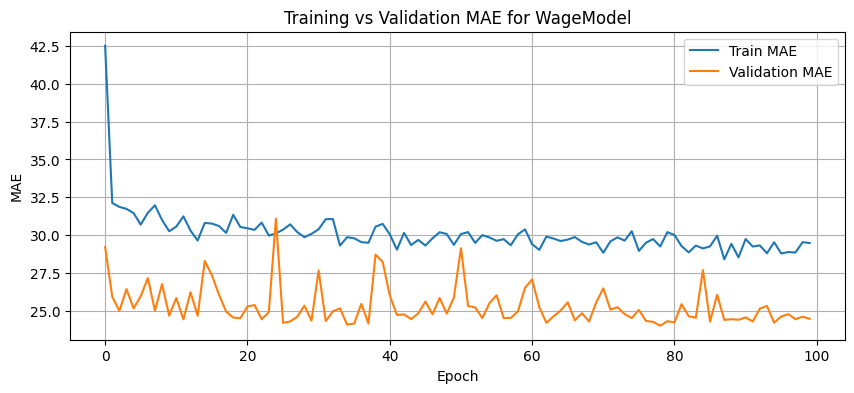

In [14]:
# Q1 Part D - Proper learning curve reconstruction 

import numpy as np
import matplotlib.pyplot as plt

df = metrics_df.copy()

# find all unique epochs
epochs = sorted(df['epoch'].unique())

train_mae_list = []
val_mae_list = []

for e in epochs:
    sub = df[df['epoch'] == e]

    # train MAE: use last non-NaN value in this epoch
    train_vals = sub['train_mae_epoch'].dropna()
    if len(train_vals) > 0:
        train_mae_list.append(train_vals.iloc[-1])
    else:
        train_mae_list.append(np.nan)

    # valid MAE: use last non-NaN value in this epoch
    val_vals = sub['valid_mae'].dropna()
    if len(val_vals) > 0:
        val_mae_list.append(val_vals.iloc[-1])
    else:
        val_mae_list.append(np.nan)

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_mae_list, label="Train MAE")
plt.plot(epochs, val_mae_list, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE for WageModel")
plt.legend()
plt.grid(True)
plt.show()


The training MAE decreases quickly at the beginning and then stabilizes around 29–30, while the validation MAE stays slightly lower and roughly flat around 24–26 across epochs.
This pattern suggests that the model does not strongly overfit and actually generalizes reasonably well to the validation data.

In [1]:
# Q2 Part A – Data Preparation (SAFE VERSION – prevents kernel crash)

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from ISLP.torch import SimpleDataModule

max_num_workers = cpu_count()

# 1. Load dataset directories
train_dir = "cats_vs_dogs_dataset/train"
test_dir = "cats_vs_dogs_dataset/test"

# 2. Image transform pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 3. Load datasets using ImageFolder (lazy loading, safe)
train_dataset_raw = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset_raw  = datasets.ImageFolder(root=test_dir,  transform=transform)

print("Classes:", train_dataset_raw.classes)
print("Training images:", len(train_dataset_raw))
print("Test images:", len(test_dataset_raw))

# 4. Use ImageFolder directly for SimpleDataModule
dm_catsdogs = SimpleDataModule(
    train_dataset_raw,
    test_dataset_raw,
    batch_size=64,
    num_workers=min(4, max_num_workers),
    validation=0.25
)

dm_catsdogs.setup("fit")

# 5. Get one batch (very fast, no memory explosion)
X_batch, y_batch = next(iter(dm_catsdogs.train_dataloader()))
print("Batch images shape:", X_batch.shape)   # expected [64, 3, 64, 64]
print("Batch labels shape:", y_batch.shape)   # expected [64]


Classes: ['cats', 'dogs']
Training images: 1000
Test images: 200
Batch images shape: torch.Size([64, 3, 64, 64])
Batch labels shape: torch.Size([64])


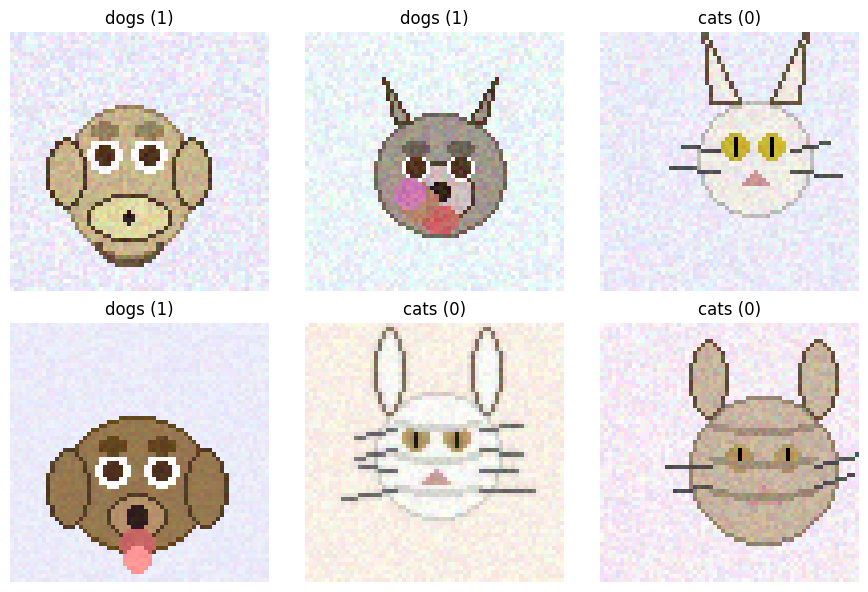

In [3]:
# Q2 Part A – Show 6 sample images

class_names = train_dataset_raw.classes 

# Undo normalization: convert back to [0,1] for display
images = X_batch[:6] * 0.5 + 0.5
labels = y_batch[:6]

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for i in range(6):
    img = images[i].permute(1, 2, 0).detach().cpu().numpy()
    label_idx = int(labels[i].item())
    axes[i].imshow(img)
    axes[i].set_title(f"{class_names[label_idx]} ({label_idx})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [4]:
# Q2 Part B - Model Definition

import torch
import torch.nn as nn
from torchinfo import summary

class CatDogCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 64x64 -> 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)            # 32x32 -> 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),              # 32 * 16 * 16
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)          # 2 classes: cat / dog
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# build model
cnn_model = CatDogCNN()

# check output shape for one batch (from Part A's X_batch)
with torch.no_grad():
    out = cnn_model(X_batch)
    print("Model output shape for one batch:", out.shape)

# model summary
summary(cnn_model, input_size=(64, 3, 64, 64))


Model output shape for one batch: torch.Size([64, 2])


Layer (type:depth-idx)                   Output Shape              Param #
CatDogCNN                                [64, 2]                   --
├─Sequential: 1-1                        [64, 32, 16, 16]          --
│    └─Conv2d: 2-1                       [64, 16, 64, 64]          448
│    └─ReLU: 2-2                         [64, 16, 64, 64]          --
│    └─MaxPool2d: 2-3                    [64, 16, 32, 32]          --
│    └─Conv2d: 2-4                       [64, 32, 32, 32]          4,640
│    └─ReLU: 2-5                         [64, 32, 32, 32]          --
│    └─MaxPool2d: 2-6                    [64, 32, 16, 16]          --
├─Sequential: 1-2                        [64, 2]                   --
│    └─Flatten: 2-7                      [64, 8192]                --
│    └─Linear: 2-8                       [64, 128]                 1,048,704
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Dropout: 2-10                     [64, 128]                 --
│   

In [8]:
# Q2 Part C - Training (Fixed for ISLP SimpleModule)

from ISLP.torch import SimpleModule, ErrorTracker
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

# Use default optimizer (Adam) and default loss (CrossEntropy)
cnn_module = SimpleModule.classification(
    cnn_model,
    num_classes=2
)

# Logger
logger = CSVLogger("logs", name="catdog")

# Trainer (30 epochs)
trainer = Trainer(
    max_epochs=30,
    deterministic=True,
    logger=logger,
    callbacks=[ErrorTracker()]
)

# Train
trainer.fit(cnn_module, datamodule=dm_catsdogs)

# Test accuracy
test_results = trainer.test(cnn_module, datamodule=dm_catsdogs)
test_acc = test_results[0]["test_accuracy"] 
print(f"Test Accuracy: {test_acc:.2f}")



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CatDogCNN        | 1.1 M  | eval 
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
1         Modules in train mode
14        Modules in eval mode


/opt/anaconda3/envs/lab10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 14 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 29: 100%|██████████| 12/12 [00:00<00:00, 40.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9549999833106995
        test_loss           0.3057299256324768
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Accuracy: 0.95


In [9]:
# Q2 Part D - Load training log for CNN

import pandas as pd
import glob

# Find the latest metrics.csv for the catdog run
metrics_file = glob.glob("logs/catdog/version_*/metrics.csv")[-1]
print("Using metrics file:", metrics_file)

metrics_df = pd.read_csv(metrics_file)
print(metrics_df.columns.tolist())
metrics_df.head()


Using metrics file: logs/catdog/version_2/metrics.csv
['epoch', 'step', 'test_accuracy', 'test_loss', 'train_accuracy_epoch', 'train_accuracy_step', 'train_loss', 'valid_accuracy', 'valid_loss']


,epoch,step,test_accuracy,test_loss,train_accuracy_epoch,train_accuracy_step,train_loss,valid_accuracy,valid_loss
0,0,11,NaN,NaN,NaN,NaN,NaN,0.760,0.495577
1,0,11,NaN,NaN,0.638667,NaN,163.496964,NaN,NaN
2,1,23,NaN,NaN,NaN,NaN,NaN,0.844,0.407772
3,1,23,NaN,NaN,0.813333,NaN,0.406835,NaN,NaN
4,2,35,NaN,NaN,NaN,NaN,NaN,0.844,0.458701


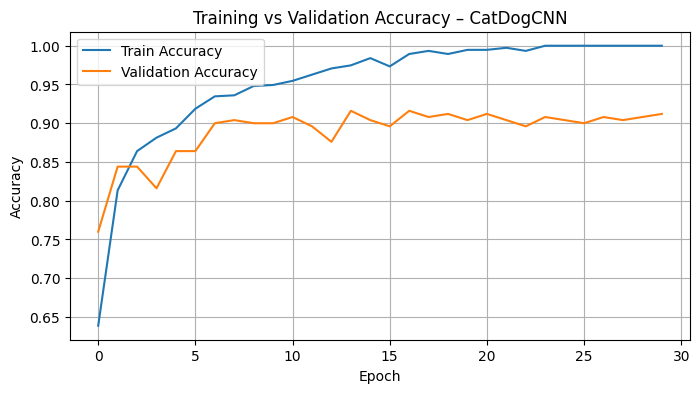

In [10]:
# Q2 Part D - Plot training vs validation accuracy

import numpy as np
import matplotlib.pyplot as plt

df = metrics_df.copy()

epochs = sorted(df["epoch"].unique())

train_acc_list = []
val_acc_list = []

for e in epochs:
    sub = df[df["epoch"] == e]

    # Training accuracy: last non-NaN value
    train_vals = sub["train_accuracy_epoch"].dropna()
    if len(train_vals) > 0:
        train_acc_list.append(train_vals.iloc[-1])
    else:
        train_acc_list.append(np.nan)

    # Validation accuracy: last non-NaN value
    val_vals = sub["valid_accuracy"].dropna()
    if len(val_vals) > 0:
        val_acc_list.append(val_vals.iloc[-1])
    else:
        val_acc_list.append(np.nan)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – CatDogCNN")
plt.legend()
plt.grid(True)
plt.show()


The training accuracy quickly rises to almost 100%, while the validation accuracy levels off around 90%. This suggests that the CNN learns the training set very well and shows some mild overfitting, but it still generalizes reasonably well to unseen images.

Compared to the feedforward network in Q1, this CNN can better capture spatial structure in images (local edges, textures, shapes) through convolution and pooling, so it handles cats vs. dogs classification more effectively than a simple fully connected network on tabular data.